# 0. Imports

In [53]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

from IPython.core.display   import HTML

## 0.1. Helper Functions

In [54]:
def settings():
    %matplotlib inline
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [10, 5]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.float_format', lambda x: '%.4f' % x)
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()

settings()

## 0.2. Loading Dataset

In [55]:
df_raw = pd.read_csv('../data/raw/train.csv')
df_raw.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0000,0,> 2 Years,Yes,40454.0000,26.0000,217,1
1,2,Male,76,1,3.0000,0,1-2 Year,No,33536.0000,26.0000,183,0
2,3,Male,47,1,28.0000,0,> 2 Years,Yes,38294.0000,26.0000,27,1
3,4,Male,21,1,11.0000,1,< 1 Year,No,28619.0000,152.0000,203,0
4,5,Female,29,1,41.0000,1,< 1 Year,No,27496.0000,152.0000,39,0


# 1. Data Description

In [56]:
df_raw.columns

Index(['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response'],
      dtype='object')

In [57]:
df1 = df_raw.copy()

In [58]:
cols_new = ['id', 'gender', 'age', 'driving_license', 'region_code', 'previously_insured', 'vehicle_age', 'vehicle_damage', 
            'annual_premium', 'policy_sales_channel', 'vintage', 'response']

df1.columns = cols_new

df1.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,Male,44,1,28.0000,0,> 2 Years,Yes,40454.0000,26.0000,217,1
1,2,Male,76,1,3.0000,0,1-2 Year,No,33536.0000,26.0000,183,0
2,3,Male,47,1,28.0000,0,> 2 Years,Yes,38294.0000,26.0000,27,1
3,4,Male,21,1,11.0000,1,< 1 Year,No,28619.0000,152.0000,203,0
4,5,Female,29,1,41.0000,1,< 1 Year,No,27496.0000,152.0000,39,0


## 1.1. Data Dimension

In [59]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Columns: {}'.format(df1.shape[1]))

Number of Rows: 381109
Number of Columns: 12


## 1.2. Data Types

In [60]:
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

## 1.3. Check NA

In [61]:
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## 1.4. Data Descriptive

In [62]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.4.1. Numerical Attributes

In [63]:
# Central Tendency: mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion: std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0000,381109.0000,381108.0000,190555.0000,190555.0000,110016.6919,0.0000,-1.2000
1,age,20.0000,85.0000,65.0000,38.8226,36.0000,15.5116,0.6725,-0.5657
2,driving_license,0.0000,1.0000,1.0000,0.9979,1.0000,0.0461,-21.5952,464.3543
3,region_code,0.0000,52.0000,52.0000,26.3888,28.0000,13.2299,-0.1153,-0.8679
4,previously_insured,0.0000,1.0000,1.0000,0.4582,0.0000,0.4983,0.1677,-1.9719
5,annual_premium,2630.0000,540165.0000,537535.0000,30564.3896,31669.0000,17213.1325,1.7661,34.0046
6,policy_sales_channel,1.0000,163.0000,162.0000,112.0343,133.0000,54.2039,-0.9000,-0.9708
7,vintage,10.0000,299.0000,289.0000,154.3474,154.0000,83.6712,0.0030,-1.2007
8,response,0.0000,1.0000,1.0000,0.1226,0.0000,0.3279,2.3019,3.2988


<AxesSubplot: xlabel='response', ylabel='count'>

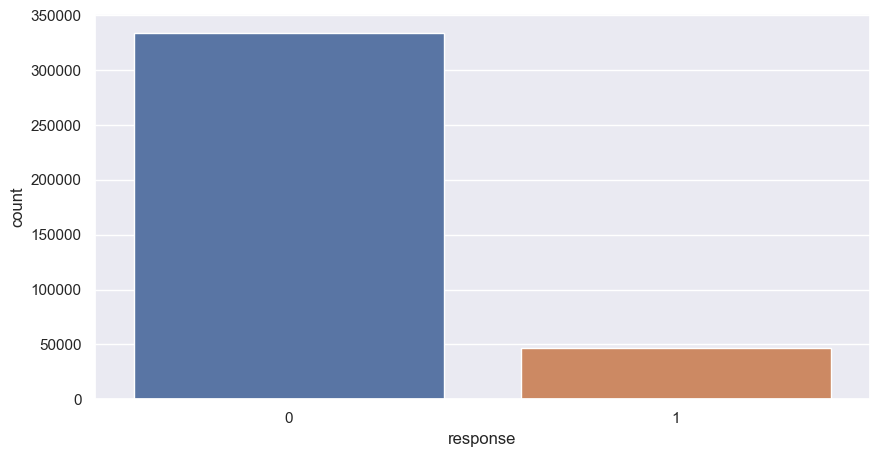

In [64]:
sns.countplot(x=df1['response'])

### 1.4.2. Categorical Attributes

In [65]:
cat_attributes.apply(lambda x: x.unique().shape[0])

gender            2
vehicle_age       3
vehicle_damage    2
dtype: int64

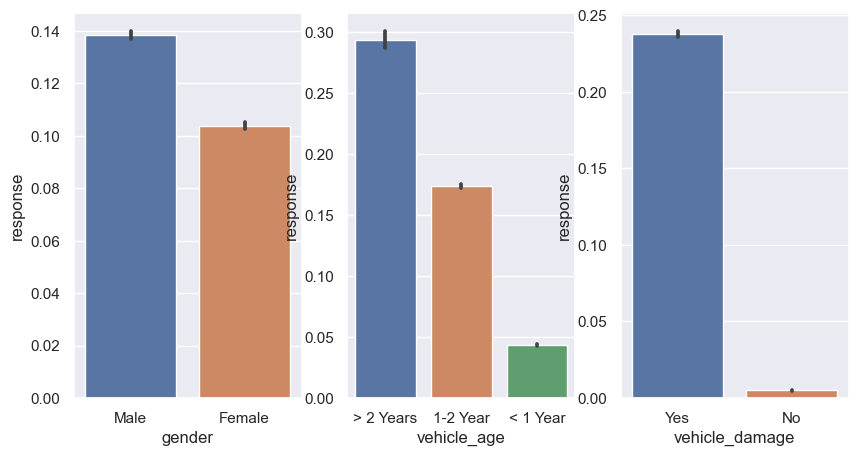

In [66]:
plt.subplot(1, 3, 1)
sns.barplot(x='gender', y='response', data=df1);

plt.subplot(1, 3, 2)
sns.barplot(x='vehicle_age', y='response', data=df1);

plt.subplot(1, 3, 3)
sns.barplot(x='vehicle_damage', y='response', data=df1);

# 2. Feature Engineering

In [67]:
df2 = df1.copy()

In [68]:
# vehicle_age
df2['vehicle_age'] = df2['vehicle_age'].apply(lambda x: 'over_2_years' if x == '> 2 Years' else 
                                                        'between_1_2_years' if x == '1-2 Year' else 'below_1_year')

# vehicle_damage
df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)

In [69]:
df2.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,Male,44,1,28.0000,0,over_2_years,1,40454.0000,26.0000,217,1
1,2,Male,76,1,3.0000,0,between_1_2_years,0,33536.0000,26.0000,183,0
2,3,Male,47,1,28.0000,0,over_2_years,1,38294.0000,26.0000,27,1
3,4,Male,21,1,11.0000,1,below_1_year,0,28619.0000,152.0000,203,0
4,5,Female,29,1,41.0000,1,below_1_year,0,27496.0000,152.0000,39,0


# 3. Data Filtering

In [70]:
df3 = df2.copy()

# 4. Exploratory Data Analysis (EDA)

In [71]:
df4 = df3.copy()

## 4.1. Univariate Analysis

In [72]:
df4.columns

Index(['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage', 'response'],
      dtype='object')

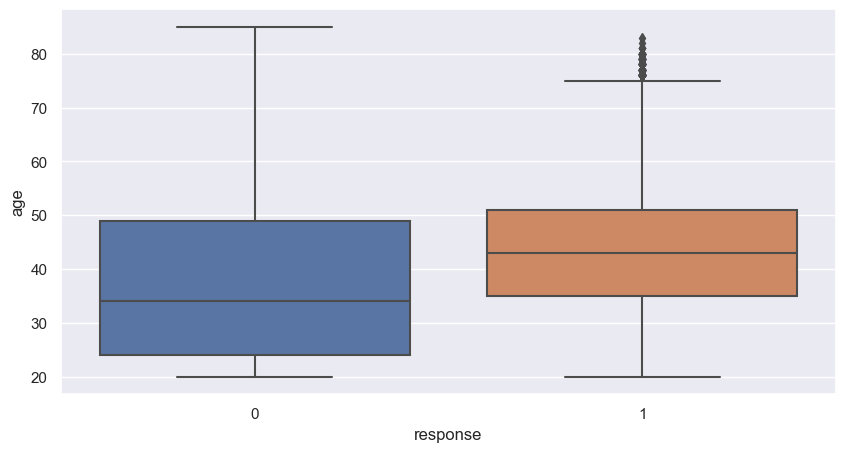

In [73]:
# age
sns.boxplot(x='response', y='age', data=df4);

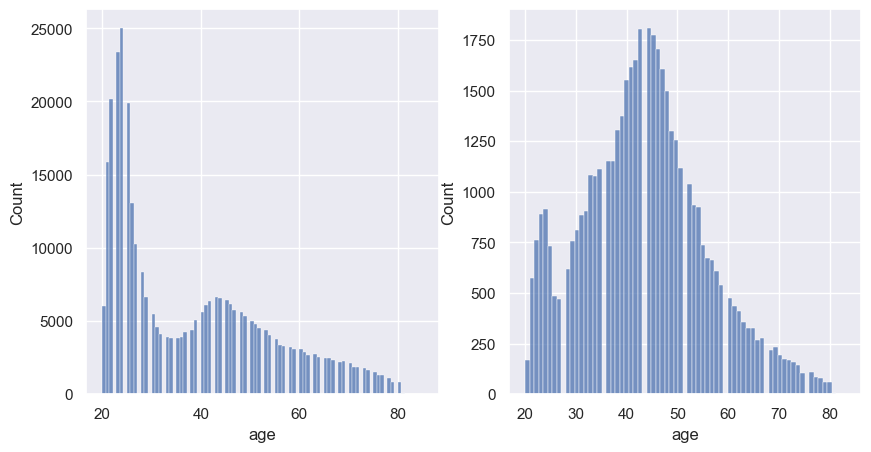

In [74]:
plt.subplot(1, 2, 1)
aux = df4.loc[df4['response'] == 0, 'age']
sns.histplot(aux);

plt.subplot(1, 2, 2)
aux = df4.loc[df4['response'] == 1, 'age']
sns.histplot(aux);

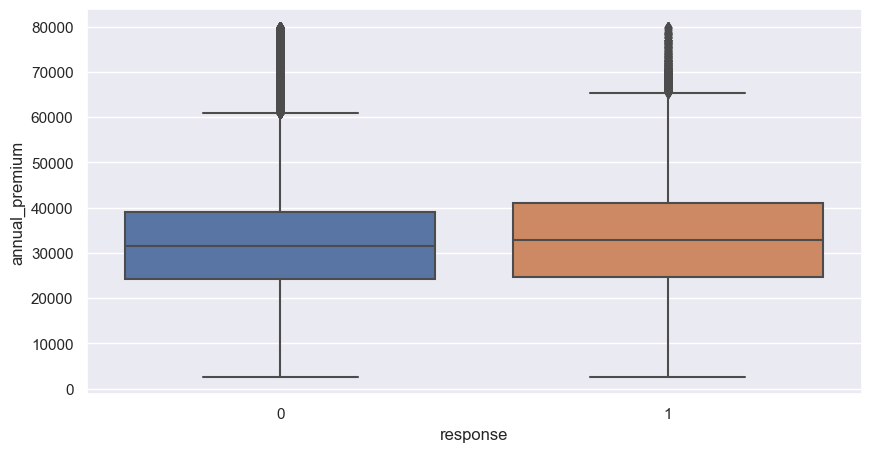

In [75]:
# annual_premmium
aux = df4[df4['annual_premium'] < 80000]
sns.boxplot(x='response', y='annual_premium', data=aux);

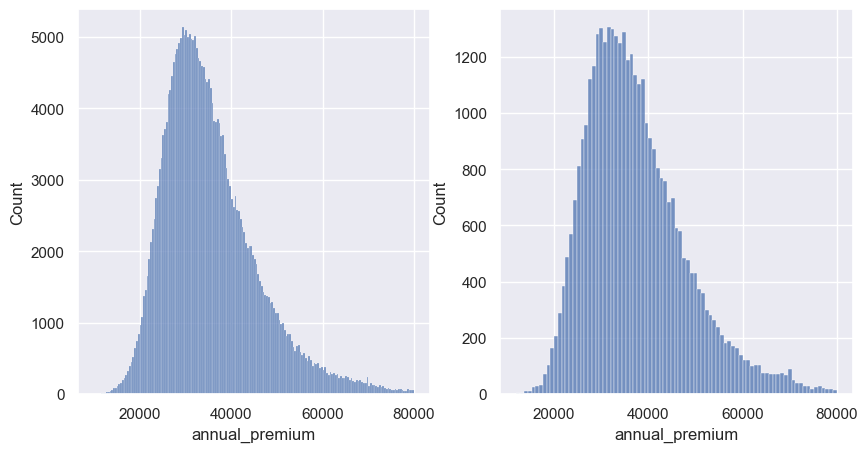

In [76]:
plt.subplot(1, 2, 1)
aux = df4[(df4['annual_premium'] > 10000) & (df4['annual_premium'] < 80000)]
aux1 = aux.loc[aux['response'] == 0, 'annual_premium']
sns.histplot(aux1);

plt.subplot(1, 2, 2)
aux = df4[(df4['annual_premium'] > 10000) & (df4['annual_premium'] < 80000)]
aux1 = aux.loc[aux['response'] == 1, 'annual_premium']
sns.histplot(aux1);

In [77]:
# driving_license
aux = df4[['driving_license', 'response']].groupby('response').sum().reset_index()
aux.head()
aux['driving_license_perc'] = aux['driving_license'] / aux['driving_license'].sum()
aux

,response,driving_license,driving_license_perc
0,0,333628,0.8773
1,1,46669,0.1227


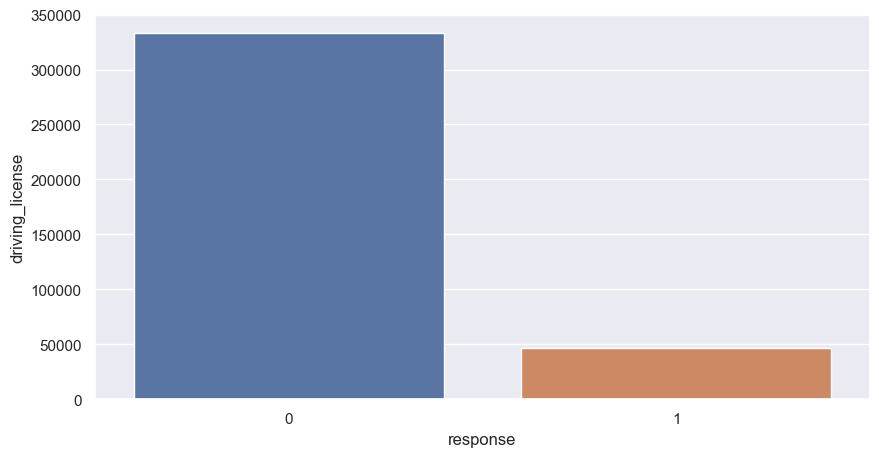

In [78]:
sns.barplot(x='response', y='driving_license', data=aux);

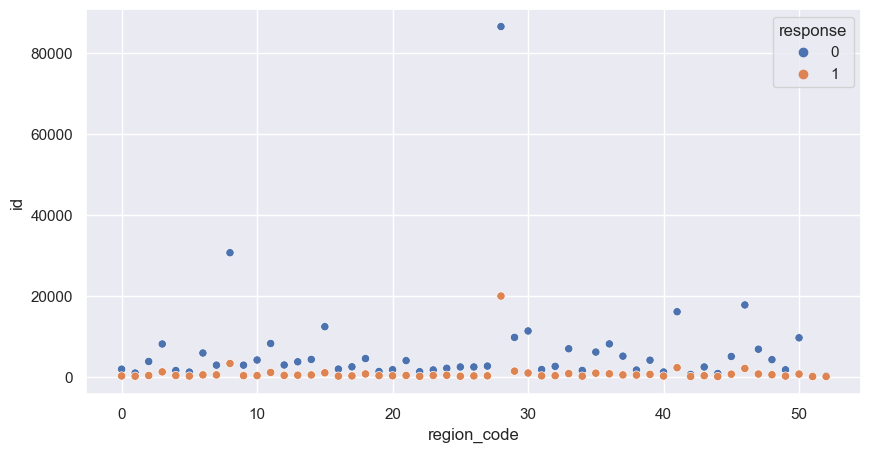

In [79]:
# region_code
aux = df4[['id', 'region_code', 'response']].groupby(['region_code', 'response']).count().reset_index()
sns.scatterplot(x='region_code', y='id', hue='response', data=aux);

In [80]:
# previously_insured
pd.crosstab(df4['previously_insured'], df4['response']).apply(lambda x: x / x.sum(), axis=1)

response,0,1
previously_insured,,
0,0.7745,0.2255
1,0.9991,0.0009


In [87]:
# vehicle_age
df4[['id', 'vehicle_age', 'response']].value_counts(normalize=True).reset_index()

In [81]:
# gender

In [83]:
# vehicle_damage

In [84]:
# policy_sales_channel

In [85]:
# vintage

# 5. Feature Selection

# 6. Data Preparation

# 7. Machine Learning